# Anime-Recommender-System-Project-2025

<center>
  <img src='https://mostaql.hsoubcdn.com/uploads/thumbnails/1450164/661a5b0c8a072/dataset-card.jpg'width='700'/>
</center>

# Table of Contents
- [1. Project Overview](#1-project-overview)
  - [1.1 Introduction](#11-introduction)
  - [1.2 Problem Statement](#12-problem-statement)
  - [1.3 Objectives](#13-objectives)
- [2. Importing Packages](#2-importing-packages)
- [3. Loading Data](#3-loading-data)
- [4. Data Cleaning](#4-data-cleaning)
- [5. Exploratory Data Analysis (EDA)](#5-exploratory-data-analysis-eda)
- [6. Preprocessing](#6-preprocessing)
- [7. Model Training](#7-model-training)
- [8. Model Evaluation](#8-model-evaluation)
- [9. Hyperparameter Tuning](#9-hyperparameter-tuning)
- [10. Conclusion](#10-conclusion)

### 1. Project Overview

##### 1.1 Introduction

##### 1.2 Problem Statement

##### 1.3 Objectives

### 2. Importing Packages

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import pandas as pd
import re
from html import unescape
import html
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity as CS
import heapq
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.metrics import calinski_harabasz_score
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.metrics import davies_bouldin_score
import warnings
warnings.filterwarnings("ignore")
%matplotlib inline

In [ ]:
df_train = pd.read_csv('train.csv')
df_test = pd.read_csv('test.csv')
df_anime = pd.read_csv('anime.csv')
df_submission = pd.read_csv('submission.csv')

#### 3.1. Exploring the Dataset
In this section, we explore the dataset to understand its structure and the information it contains. The code snippets below provide an overview of the dataset's shape, the number of columns, and metadata information about the dataset.

In [ ]:
# Reading the anime.csv file into a DataFrame
anime_df = pd.read_csv('anime.csv')
anime_df.head(3)

anime_id                              name  \
0     32281                    Kimi no Na wa.   
1      5114  Fullmetal Alchemist: Brotherhood   
2     28977                          Gintama°   

                                               genre   type episodes  rating  \
0               Drama, Romance, School, Supernatural  Movie        1    9.37   
1  Action, Adventure, Drama, Fantasy, Magic, Mili...     TV       64    9.26   
2  Action, Comedy, Historical, Parody, Samurai, S...     TV       51    9.25   

   members  
0   200630  
1   793665  
2   114262

In [ ]:
# Reading the train.zip (csv) file into a DataFrame
train_df = pd.read_csv('train.csv')
train_df.head(3)

user_id  anime_id  rating
0        1     11617      10
1        1     11757      10
2        1     15451      10

In [ ]:
# Reading the test.csv file into a DataFrame
test_df = pd.read_csv('test.csv')
test_df.head(3)

user_id  anime_id
0    40763     21405
1    68791     10504
2    40487      1281

### 4. Data Cleaning

#### 4.1. Missing value

_This code checks for missing values in three datasets: anime_df, train_df, and test_df. It uses the .isnull().sum() function to count the number of missing values in each column of the respective DataFrames. The results are printed to help identify any gaps in the data that may need to be handled before further analysis or modeling._

In [ ]:
# Check for missing values
print("Missing values in anime_df:")
print(anime_df.isnull().sum())
print("\nMissing values in train_df:")
print(train_df.isnull().sum())
print("\nMissing values in test_df:")
print(test_df.isnull().sum())

Missing values in anime_df:
anime_id      0
name          0
genre        62
type         25
episodes      0
rating      230
members       0
dtype: int64

Missing values in train_df:
user_id     0
anime_id    0
rating      0
dtype: int64

Missing values in test_df:
user_id     0
anime_id    0
dtype: int64


#### 4.2 Drop Duplicates

_This code removes duplicate rows from the anime_df, train_df, and test_df DataFrames using the .drop_duplicates(inplace=True) method. Removing duplicates ensures data consistency and prevents redundant information from affecting analysis or model training. The inplace=True parameter modifies the DataFrame directly without needing to assign it to a new variable._

In [ ]:
# Remove duplicates if any
anime_df.drop_duplicates(inplace=True)
train_df.drop_duplicates(inplace=True)
test_df.drop_duplicates(inplace=True)

#### 4.3. Cleaning anime_df

_This function, clean_anime_df(df), is designed to clean and preprocess an anime dataset by ensuring data consistency, handling missing values, and standardizing text formatting._

In [ ]:
from html import unescape  # ✅ Import unescape to avoid NameError
import re
import pandas as pd

def clean_anime_df(df):
    # Ensure anime_id is unique and non-null
    assert df['anime_id'].is_unique, "anime_id column has duplicate values."
    assert df['anime_id'].notnull().all(), "anime_id column has null values."
    df['anime_id'] = df['anime_id'].astype(int)

    # Function to clean names and unescape HTML entities
    def clean_name(name):
        name = unescape(name)  # ✅ Convert HTML entities to characters
        name = name.lower().strip()  # Convert to lowercase and strip whitespace
        name = name.replace("&#039;", "'").replace("°", "")
        name = re.sub(r'[^a-zA-Z0-9\s\.\,\-\&\:\;\']', '', name)  # Remove unwanted special characters
        return name

    # Apply the cleaning function to the 'name' column
    df['name'] = df['name'].apply(clean_name)

    # Handle missing values in 'genre' and split into lists
    df['genre'] = df['genre'].fillna('')
    df['genre'] = df['genre'].apply(lambda x: x.split(', '))

    # Standardize genre lists
    df['genre'] = df['genre'].apply(lambda genres: [genre.strip().lower() for genre in genres])

    # Standardize the 'type' column
    df['type'] = df['type'].str.lower().str.strip().fillna('unknown')

    # Ensure episodes is numeric and handle missing values
    df['episodes'] = pd.to_numeric(df['episodes'], errors='coerce').fillna(-1).astype(int)

    # Ensure rating is numeric and handle missing values
    df['rating'] = pd.to_numeric(df['rating'], errors='coerce').fillna(-1.0)

    # Ensure members is numeric and handle missing values
    df['members'] = pd.to_numeric(df['members'], errors='coerce').fillna(0).astype(int)

    return df

# Example usage:
# anime_df = clean_anime_df(anime_df)


In [ ]:
# Clean the dataframes
anime_df = clean_anime_df(anime_df)

# Display the first few rows of the cleaned dataframes for verification
print(f'Cleaned anime_df:\n{anime_df.head()}')

Cleaned anime_df:
   anime_id                              name  \
0     32281                    kimi no na wa.   
1      5114  fullmetal alchemist: brotherhood   
2     28977                           gintama   
3      9253                       steins;gate   
4      9969                          gintama'   

                                               genre   type  episodes  rating  \
0             [drama, romance, school, supernatural]  movie         1    9.37   
1  [action, adventure, drama, fantasy, magic, mil...     tv        64    9.26   
2  [action, comedy, historical, parody, samurai, ...     tv        51    9.25   
3                                 [sci-fi, thriller]     tv        24    9.17   
4  [action, comedy, historical, parody, samurai, ...     tv        51    9.16   

   members  
0   200630  
1   793665  
2   114262  
3   673572  
4   151266  


#### 4.4. Cleaning train data

_This function cleans the train_df DataFrame, ensuring that user_id, anime_id, and rating are valid and properly formatted._

In [ ]:
# Define function to clean train_df
def clean_train_df(df):
    # Ensure user_id and anime_id are non-null and numeric
    df = df.dropna(subset=['user_id', 'anime_id'])
    df['user_id'] = pd.to_numeric(df['user_id'], errors='coerce')
    df['anime_id'] = pd.to_numeric(df['anime_id'], errors='coerce')

    # Handle ratings: ensure they are integers and within a valid range
    df['rating'] = pd.to_numeric(df['rating'], errors='coerce')

    # Option 1: Filter out rows where rating is -1, ensuring rating remains an integer
    df = df[df['rating'] != -1]

    # Remove remaining rows with NaN values that could not be converted
    df.dropna(subset=['user_id', 'anime_id', 'rating'], inplace=True)

    # Ensure the remaining ratings are within the valid range
    df = df[(df['rating'] >= 1) & (df['rating'] <= 10)]
    df['rating'] = df['rating'].astype(int)  # Ensure rating column is of integer type

    return df

In [ ]:
# Clean the dataframes
train_df = clean_train_df(train_df)

# Display the first few rows of the cleaned dataframes for verification
print(f'Cleaned train_df:\n{train_df.head()}')

Cleaned train_df:
   user_id  anime_id  rating
0        1     11617      10
1        1     11757      10
2        1     15451      10
3        2     11771      10
4        3        20       8


#### 4.5. Cleaning test data

_This function cleans the test_df DataFrame by ensuring that user_id and anime_id are valid numeric values and do not contain missing or invalid entries._

In [ ]:
# Define function to clean test_df
def clean_test_df(df):
    # Ensure user_id and anime_id are non-null and numeric
    df = df.dropna(subset=['user_id', 'anime_id'])
    df['user_id'] = pd.to_numeric(df['user_id'], errors='coerce')
    df['anime_id'] = pd.to_numeric(df['anime_id'], errors='coerce')

    # Remove rows with NaN values that could not be converted
    df.dropna(subset=['user_id', 'anime_id'], inplace=True)

    return df

In [ ]:
# Clean the dataframes
test_df = clean_test_df(test_df)

# Display the first few rows of the cleaned dataframes for verification
print(f'Cleaned test_df:\n{test_df.head()}')

Cleaned test_df:
   user_id  anime_id
0    40763     21405
1    68791     10504
2    40487      1281
3    55290       165
4    72323     11111


### 5. Exploratory Data Analysis (EDA)

#### 5.1 EDA on anime_df
Summary Statistics: Get an overview of the dataset.
Distribution of Anime Types: Analyze the types of anime (e.g., TV, Movie, OVA).
Distribution of Genres: Analyze the genres and their frequency.
Rating Distribution: Visualize the distribution of anime ratings.
Members Distribution: Analyze the distribution of the number of members who have rated the anime.

In [ ]:
# Summary statistics for anime_df
print("Summary statistics for anime_df:")
print(anime_df.describe())

Summary statistics for anime_df:
           anime_id      episodes        rating       members
count  12294.000000  12294.000000  12294.000000  1.229400e+04
mean   14058.221653     12.012445      6.334078  1.807134e+04
std    11455.294701     46.264788      1.435287  5.482068e+04
min        1.000000     -1.000000     -1.000000  5.000000e+00
25%     3484.250000      1.000000      5.820000  2.250000e+02
50%    10260.500000      2.000000      6.550000  1.550000e+03
75%    24794.500000     12.000000      7.170000  9.437000e+03
max    34527.000000   1818.000000     10.000000  1.013917e+06


#### 5.2. Distribution of Rating

_This code visualizes the distribution of anime ratings in the dataset using a histogram with Kernel Density Estimation (KDE)._

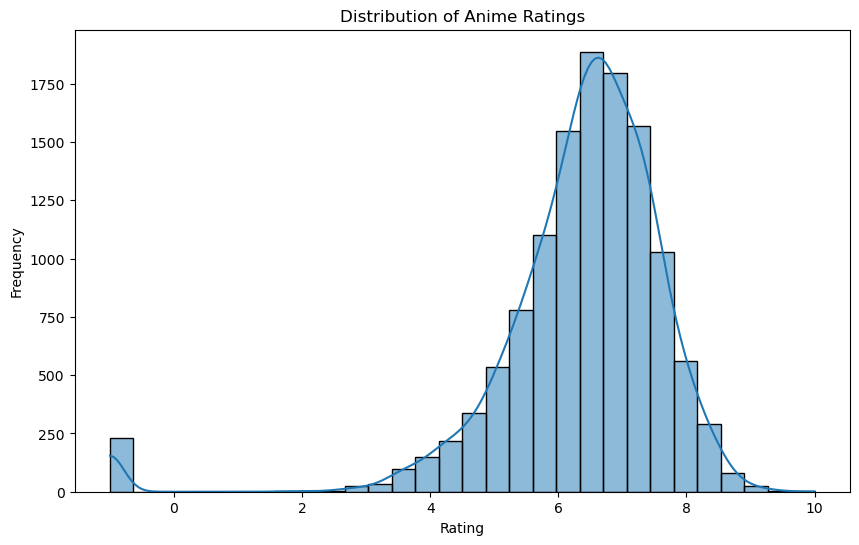

In [ ]:
# Distribution of anime ratings
plt.figure(figsize=(10, 6))
sns.histplot(anime_df['rating'], bins=30, kde=True)
plt.title('Distribution of Anime Ratings')
plt.xlabel('Rating')
plt.ylabel('Frequency')
plt.show()

#### 5.3. Distribution of Number of Members

_This code visualizes the distribution of the number of members (viewers) for each anime in the dataset using a histogram with a Kernel Density Estimate (KDE)._

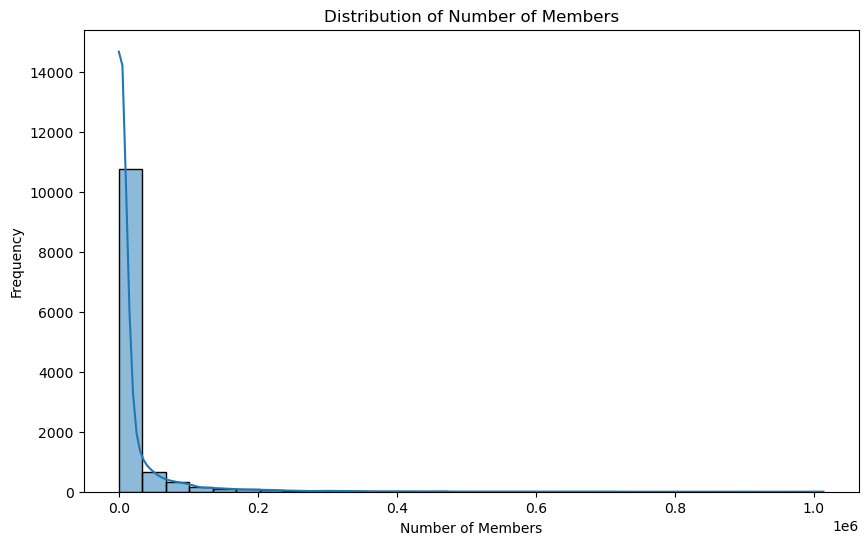

In [ ]:
# Distribution of number of members
plt.figure(figsize=(10, 6))
sns.histplot(anime_df['members'], bins=30, kde=True)
plt.title('Distribution of Number of Members')
plt.xlabel('Number of Members')
plt.ylabel('Frequency')
plt.show()

#### 5.4. Rating by Anime Type

_This code creates a box plot to visualize the distribution of anime ratings for different types of anime._

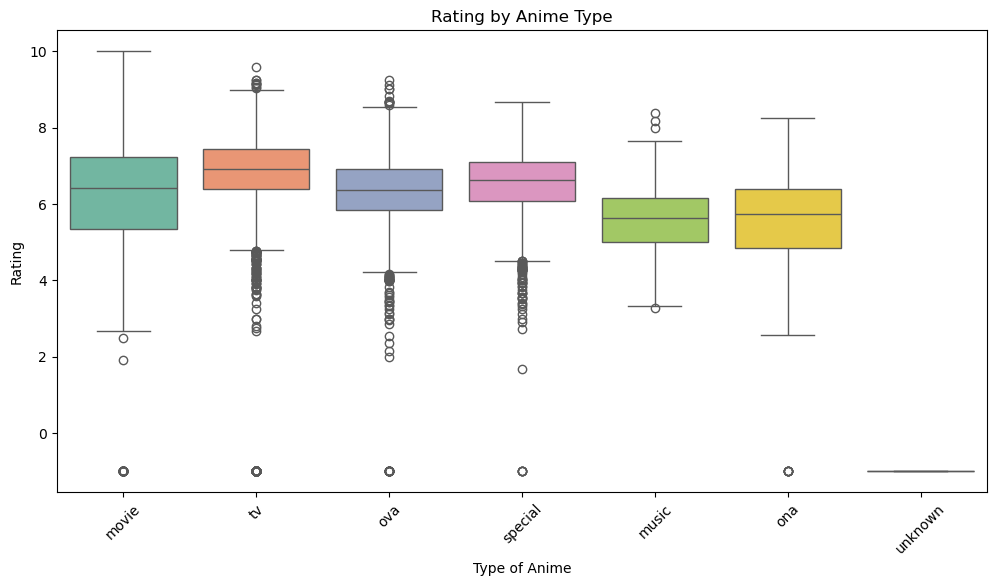

In [ ]:
plt.figure(figsize=(12, 6))
sns.boxplot(x='type', y='rating', data=anime_df, palette="Set2")  # Try 'husl', 'coolwarm', 'pastel', etc.
plt.title('Rating by Anime Type')
plt.xlabel('Type of Anime')
plt.ylabel('Rating')
plt.xticks(rotation=45)
plt.show()


#### 5.5. Top 10 Most Popular Anime

_This code generates a horizontal bar plot to visualize the top 10 most popular anime based on the number of members._

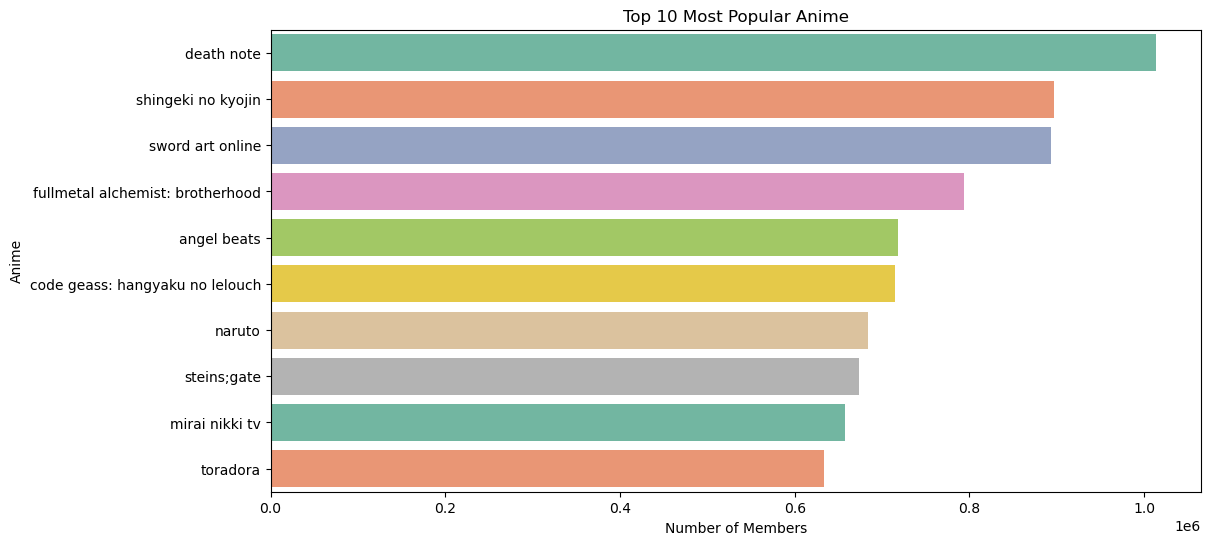

In [ ]:
# Top 10 most popular anime
top_10_anime = anime_df.sort_values(by='members', ascending=False).head(10)

# Define a custom color palette with distinct colors
colors = sns.color_palette("Set2", len(top_10_anime))  # You can change "Set2" to other palettes like "Set1", "Paired", etc.

plt.figure(figsize=(12, 6))
sns.barplot(x='members', y='name', data=top_10_anime, palette=colors, orient='h')
plt.title('Top 10 Most Popular Anime')
plt.xlabel('Number of Members')
plt.ylabel('Anime')
plt.show()


#### 5.6. Correlation Matrix

_This code generates a correlation matrix heatmap to visualize relationships between numerical variables (rating, members, and episodes) in the anime dataset._

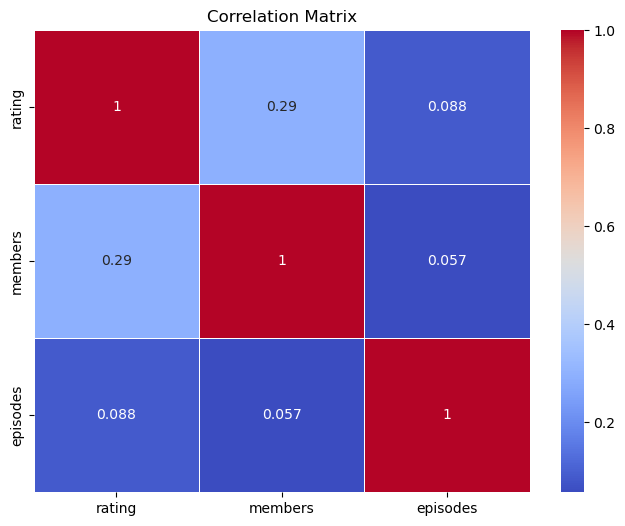

In [ ]:
# Correlation matrix
corr_matrix = anime_df[['rating', 'members', 'episodes']].corr()
plt.figure(figsize=(8, 6))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', linewidths=0.5)
plt.title('Correlation Matrix')
plt.show()

#### 5.7. User Rating Distribution

_This code visualizes the distribution of user ratings in the train_df dataset using a histogram._

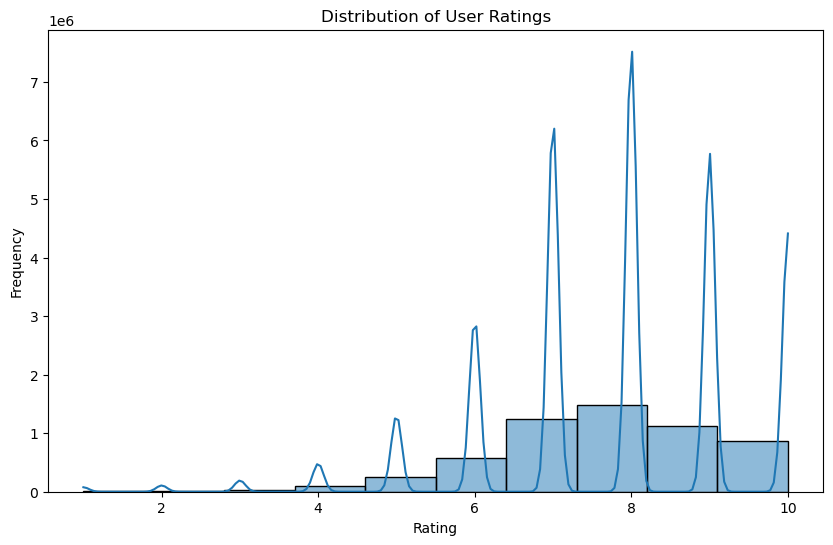

In [ ]:
# Distribution of user ratings
plt.figure(figsize=(10, 6))
sns.histplot(train_df['rating'], bins=10, kde=True)
plt.title('Distribution of User Ratings')
plt.xlabel('Rating')
plt.ylabel('Frequency')
plt.show()

#### 5.8. Top Rated Animes by Users

_This code visualizes the top 10 highest-rated anime by users based on their average ratings._

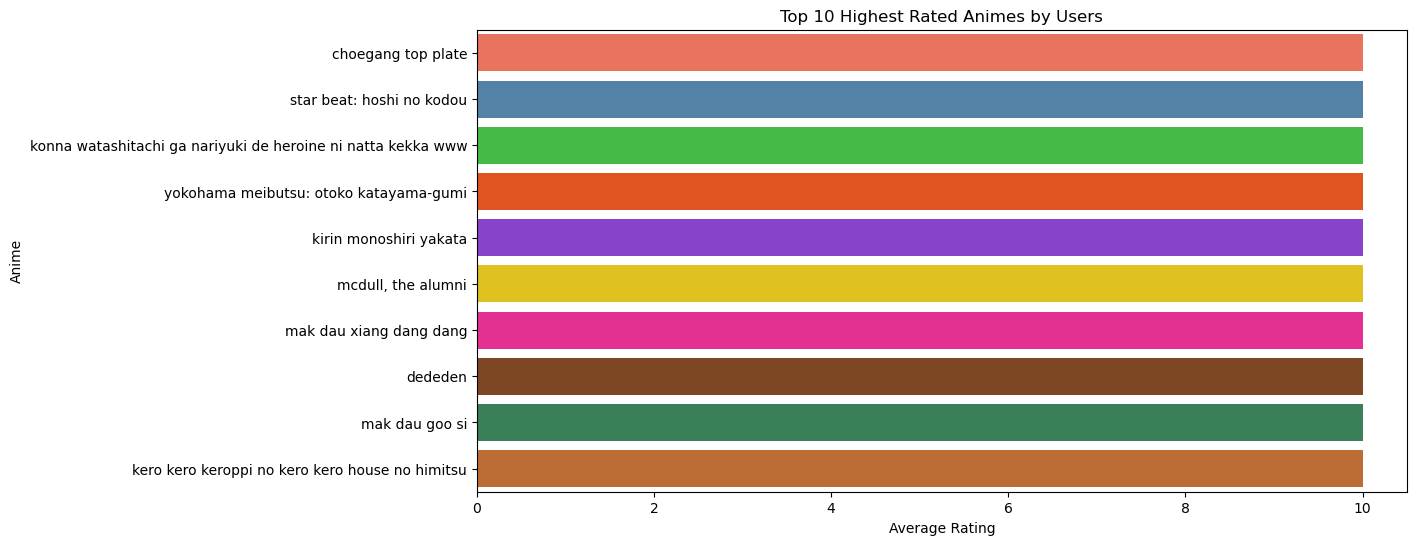

In [ ]:
# Top rated animes by users
top_rated_animes = train_df.groupby('anime_id').mean()['rating'].sort_values(ascending=False).head(10).reset_index()
top_rated_animes = top_rated_animes.merge(anime_df[['anime_id', 'name']], on='anime_id')

# Define a custom list of colors for the bars (you can replace these with any color codes you like)
colors = ['#FF6347', '#4682B4', '#32CD32', '#FF4500', '#8A2BE2', '#FFD700', '#FF1493', '#8B4513', '#2E8B57', '#D2691E']

# Create the plot
plt.figure(figsize=(12, 6))
sns.barplot(x='rating', y='name', data=top_rated_animes, palette=colors, orient='h')
plt.title('Top 10 Highest Rated Animes by Users')
plt.xlabel('Average Rating')
plt.ylabel('Anime')
plt.show()


### 6. Preprocessing

##### Anime_df

In [ ]:
import pandas as pd
from sklearn.feature_extraction.text import CountVectorizer

# This is for the models and its added by me, Sanele
or_anime_df = anime_df
# Ensure 'genre' is a string before processing
anime_df['genre'] = anime_df['genre'].astype(str)

# Use CountVectorizer to create a one-hot encoded matrix for genres
vectorizer = CountVectorizer(tokenizer=lambda x: x.strip("[]").replace("'", "").split(", "))
genre_matrix = vectorizer.fit_transform(anime_df['genre'])

# Convert the matrix to a DataFrame
genre_df = pd.DataFrame(genre_matrix.toarray(), columns=vectorizer.get_feature_names_out())

# Concatenate one-hot encoded genres with the original DataFrame
anime_df = pd.concat([anime_df, genre_df], axis=1)

# Display anime_df
anime_df.head()


anime_id                              name  \
0     32281                    kimi no na wa.   
1      5114  fullmetal alchemist: brotherhood   
2     28977                           gintama   
3      9253                       steins;gate   
4      9969                          gintama'   

                                               genre   type  episodes  rating  \
0     ['drama', 'romance', 'school', 'supernatural']  movie         1    9.37   
1  ['action', 'adventure', 'drama', 'fantasy', 'm...     tv        64    9.26   
2  ['action', 'comedy', 'historical', 'parody', '...     tv        51    9.25   
3                             ['sci-fi', 'thriller']     tv        24    9.17   
4  ['action', 'comedy', 'historical', 'parody', '...     tv        51    9.16   

   members     action  adventure  ...  shounen ai  slice of life  space  \
0   200630  0       0          0  ...           0              0      0   
1   793665  0       1          1  ...           0              0      0   
2   114262  0       1          0  ...           0              0      0   
3   673572  0       0          0  ...           0              0      0   
4   151266  0       1          0  ...           0              0      0   

   sports  super power  supernatural  thriller  vampire  yaoi  yuri  
0       0            0             1         0        0     0     0  
1       0            0             0         0        0     0     0  
2       0            0             0         0        0     0     0  
3       0            0             0         1        0     0     0  
4       0            0             0         0        0     0     0  

[5 rows x 51 columns]

##### Train_df

In [ ]:
### Merge train_df with anime_df to include anime details
'''train_df = train_df.merge(anime_df, on='anime_id', how='left')

# Normalize ratings
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
train_df['rating_x'] = scaler.fit_transform(train_df[['rating_x']])'''

# Display train_df
train_df.head()


user_id  anime_id  rating
0        1     11617      10
1        1     11757      10
2        1     15451      10
3        2     11771      10
4        3        20       8

##### Test_df

In [ ]:
# Merge test_df with anime_df to include anime details
#test_df = test_df.merge(anime_df, on='anime_id', how='left')
# Display test_df
test_df.head()

user_id  anime_id
0    40763     21405
1    68791     10504
2    40487      1281
3    55290       165
4    72323     11111

### 7. Model Training

#### 7.1. Content-Based Filtering

In this section, content-based recommendation algorithms and models are developed. The models are built using the recommendation algorithms as the foundation.

##### *7.1.1. Cosine Similarity Matrix Recommender*

Starting with the cosine similarity for content based recommender

In [ ]:
# We use the anime_df
anime_df['anime_tags'] = (pd.Series(anime_df[['genre', 'type']]
                          .fillna('')
                          .values.tolist()).str.join(' '))

anime_df['anime_tags'].head()

0    ['drama', 'romance', 'school', 'supernatural']...
1    ['action', 'adventure', 'drama', 'fantasy', 'm...
2    ['action', 'comedy', 'historical', 'parody', '...
3                            ['sci-fi', 'thriller'] tv
4    ['action', 'comedy', 'historical', 'parody', '...
Name: anime_tags, dtype: object

In [ ]:
anime_titles = anime_df['name']

indices = pd.Series(anime_df.index, index=anime_df['name'])

In [ ]:
vectorizer = TfidfVectorizer(analyzer='word', ngram_range=(1,3),
                             min_df=0.0, stop_words='english')

anime_tags_vector_matrix = vectorizer.fit_transform(anime_df['anime_tags'])

In [ ]:
cs_anime_tags = CS(anime_tags_vector_matrix,
                   anime_tags_vector_matrix)

cs_anime_tags.shape

(12294, 12294)

In [ ]:
def top_k_recommendations(anime_title, k=10):

    def sort_by_similarity(item):
        return item[1]


    title_index = indices[anime_title]

    sim_scores = list(enumerate(cs_anime_tags[title_index].tolist()))
    sim_scores = sorted(sim_scores, key=sort_by_similarity, reverse=True)
    sim_scores = sim_scores[1:k]

    anime_indices = [i[0] for i in sim_scores]

    return anime_titles.iloc[anime_indices]

In [ ]:
top_k_recommendations('fullmetal alchemist: brotherhood', 10)

200                               fullmetal alchemist
402         fullmetal alchemist: brotherhood specials
1558    fullmetal alchemist: the sacred star of milos
6868                              jikuu tenshou nazca
4264                                   tide-line blue
2486                lodoss-tou senki: eiyuu kishi den
5709                                            arion
879               tales of vesperia: the first strike
723                          hai to gensou no grimgar
Name: name, dtype: object

In [ ]:
top_k_recommendations('death note', 10)

981                   mousou dairinin
778                death note rewrite
144     higurashi no naku koro ni kai
334         higurashi no naku koro ni
1238                        shigofumi
5143                         kagewani
5144                   kagewani: shou
38                            monster
2199                  mouryou no hako
Name: name, dtype: object

In [ ]:
print(len(train_df))
print(len(anime_df))

5703554
12294


In [ ]:
len(anime_df['name'].unique())

12273

##### *Cosine Similarity Matrix Rating Predictor*

We use the cosine similarity matrix from 7.1.1. to generate predictions of the ratings.

In [ ]:
def rating_predictor(anime_title, user, rating_data, k=20, threshold=0.0):

    def get_similarity(neighbor):
        return neighbor[0]

    title_index = indices[anime_title]
    neighbors = []

    for index, row in rating_data[rating_data['user_id']==user].iterrows():
        sim = cs_anime_tags[title_index-1, indices[row['name']]-1]
        if isinstance(sim, np.ndarray):
            if sim.shape == (2,):
                sim = sim[0]
            elif sim.size == 1:
                sim = sim.item()
        neighbors.append((sim, row['rating']))
    k_neighbors = sorted(neighbors, key=get_similarity, reverse=True)[:k]

    simTotal, weightedSum = 0, 0
    for (simScore, rating) in k_neighbors:
        if (simScore > threshold):
            simTotal += simScore
            weightedSum += simScore * rating
    try:
        predictedRating = weightedSum / simTotal
    except ZeroDivisionError:
        predictedRating = np.mean(rating_data[rating_data['name']==anime_title]['rating'])

    return round(predictedRating, 0)

In [ ]:
ratings = train_df.merge(anime_df[['anime_id', 'name']],
                         on='anime_id', how='left')
ratings.head()

user_id  anime_id  rating                 name
0        1     11617      10      high school dxd
1        1     11757      10     sword art online
2        1     15451      10  high school dxd new
3        2     11771      10     kuroko no basket
4        3        20       8               naruto

In [ ]:
title = "mob psycho 100"
user_id = 5
actual_rating = ratings[(ratings['user_id'] == user_id) & (ratings['name'] == title)]['rating'].values[0]
#actual_rating = None
pred_rating = rating_predictor(anime_title=title, user=user_id, rating_data=ratings)
print (f"Title - {title}")
print ("---")
print (f"Actual rating: \t\t {actual_rating}")
print (f"Predicted rating: \t {pred_rating}")

Title - mob psycho 100
---
Actual rating: 		 9
Predicted rating: 	 6.0


In [ ]:
ratings[ratings['user_id'] == 5]

user_id  anime_id  rating                                   name
89         5         6       8                                 trigun
90         5        15       6                           eyeshield 21
91         5        17       6             hungry heart: wild striker
92         5        18       6                 initial d fourth stage
93         5        20       6                                 naruto
..       ...       ...     ...                                    ...
496        5     30831       8  kono subarashii sekai ni shukufuku wo
497        5     31240       8  re:zero kara hajimeru isekai seikatsu
498        5     31722       7  nanatsu no taizai: seisen no shirushi
499        5     32182       9                         mob psycho 100
500        5     32828       7                      amaama to inazuma

[412 rows x 4 columns]

In [ ]:
anime_df['anime_tags']

0        ['drama', 'romance', 'school', 'supernatural']...
1        ['action', 'adventure', 'drama', 'fantasy', 'm...
2        ['action', 'comedy', 'historical', 'parody', '...
3                                ['sci-fi', 'thriller'] tv
4        ['action', 'comedy', 'historical', 'parody', '...
                               ...                        
12289                                       ['hentai'] ova
12290                                       ['hentai'] ova
12291                                       ['hentai'] ova
12292                                       ['hentai'] ova
12293                                     ['hentai'] movie
Name: anime_tags, Length: 12294, dtype: object

In [ ]:
base_model_ratings = train_df.groupby('anime_id')['rating'].mean().reset_index()
base_model_ratings = pd.DataFrame(base_model_ratings)
base_model_ratings.fillna(base_model_ratings['rating'].mean(), inplace=True)

In [ ]:
base_model_ratings

anime_id    rating
0            1  8.866166
1            5  8.446497
2            6  8.414669
3            7  7.531937
4            8  7.194030
...        ...       ...
9833     34324  5.909091
9834     34325  7.357143
9835     34349  7.000000
9836     34367  5.333333
9837     34475  6.666667

[9838 rows x 2 columns]

In [ ]:
base_model = pd.merge(test_df, base_model_ratings, how='left')
base_model.sort_values(by='user_id', inplace=True)

In [ ]:
base_model['ID'] = base_model['user_id'].astype(str) + '_' + base_model['anime_id'].astype(str)

base_model = base_model[['ID', 'rating']]
base_model

ID    rating
590213       1_8074  7.673601
613843       3_5114  9.323551
356777      3_20583  8.712891
477168      3_23321  7.753709
111841      3_20507  8.225646
...             ...       ...
386021   73515_6919  6.663883
83187    73515_1165  6.887755
316880  73515_13599  7.586948
560460     73515_27  7.617737
335960    73516_790  8.206458

[633686 rows x 2 columns]

In [ ]:
base_model.fillna(base_model['rating'].mean(), inplace=True)

In [ ]:
base_model.isnull().sum()

ID        0
rating    0
dtype: int64

In [ ]:
base_model.info()

<class 'pandas.core.frame.DataFrame'>
Index: 633686 entries, 590213 to 335960
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   ID      633686 non-null  object 
 1   rating  633686 non-null  float64
dtypes: float64(1), object(1)
memory usage: 14.5+ MB


##### 7.1.2. *Cluster Recommendation Systems*

In [ ]:
or_anime_df.head()

anime_id                              name  \
0     32281                    kimi no na wa.   
1      5114  fullmetal alchemist: brotherhood   
2     28977                           gintama   
3      9253                       steins;gate   
4      9969                          gintama'   

                                               genre   type  episodes  rating  \
0     ['drama', 'romance', 'school', 'supernatural']  movie         1    9.37   
1  ['action', 'adventure', 'drama', 'fantasy', 'm...     tv        64    9.26   
2  ['action', 'comedy', 'historical', 'parody', '...     tv        51    9.25   
3                             ['sci-fi', 'thriller']     tv        24    9.17   
4  ['action', 'comedy', 'historical', 'parody', '...     tv        51    9.16   

   members  
0   200630  
1   793665  
2   114262  
3   673572  
4   151266

In [ ]:
or_anime_df['episodes'].max()

1818

In [ ]:
or_anime_df['rounded_rating'] = or_anime_df['rating'].round(0)
or_anime_df.head()

anime_id                              name  \
0     32281                    kimi no na wa.   
1      5114  fullmetal alchemist: brotherhood   
2     28977                           gintama   
3      9253                       steins;gate   
4      9969                          gintama'   

                                               genre   type  episodes  rating  \
0     ['drama', 'romance', 'school', 'supernatural']  movie         1    9.37   
1  ['action', 'adventure', 'drama', 'fantasy', 'm...     tv        64    9.26   
2  ['action', 'comedy', 'historical', 'parody', '...     tv        51    9.25   
3                             ['sci-fi', 'thriller']     tv        24    9.17   
4  ['action', 'comedy', 'historical', 'parody', '...     tv        51    9.16   

   members  rounded_rating  
0   200630             9.0  
1   793665             9.0  
2   114262             9.0  
3   673572             9.0  
4   151266             9.0

In [ ]:
or_anime_df['rounded_rating'] = or_anime_df['rounded_rating'].astype(int)
or_anime_df.head()

anime_id                              name  \
0     32281                    kimi no na wa.   
1      5114  fullmetal alchemist: brotherhood   
2     28977                           gintama   
3      9253                       steins;gate   
4      9969                          gintama'   

                                               genre   type  episodes  rating  \
0     ['drama', 'romance', 'school', 'supernatural']  movie         1    9.37   
1  ['action', 'adventure', 'drama', 'fantasy', 'm...     tv        64    9.26   
2  ['action', 'comedy', 'historical', 'parody', '...     tv        51    9.25   
3                             ['sci-fi', 'thriller']     tv        24    9.17   
4  ['action', 'comedy', 'historical', 'parody', '...     tv        51    9.16   

   members  rounded_rating  
0   200630               9  
1   793665               9  
2   114262               9  
3   673572               9  
4   151266               9

In [ ]:
or_anime_df['selected_feats'] = or_anime_df['genre'] + ' ' + or_anime_df['type'] + ' ' +or_anime_df['genre'].astype(str)

In [ ]:
or_anime_df.head()

anime_id                              name  \
0     32281                    kimi no na wa.   
1      5114  fullmetal alchemist: brotherhood   
2     28977                           gintama   
3      9253                       steins;gate   
4      9969                          gintama'   

                                               genre   type  episodes  rating  \
0     ['drama', 'romance', 'school', 'supernatural']  movie         1    9.37   
1  ['action', 'adventure', 'drama', 'fantasy', 'm...     tv        64    9.26   
2  ['action', 'comedy', 'historical', 'parody', '...     tv        51    9.25   
3                             ['sci-fi', 'thriller']     tv        24    9.17   
4  ['action', 'comedy', 'historical', 'parody', '...     tv        51    9.16   

   members  rounded_rating                                     selected_feats  
0   200630               9  ['drama', 'romance', 'school', 'supernatural']...  
1   793665               9  ['action', 'adventure', 'drama', 'fantasy', 'm...  
2   114262               9  ['action', 'comedy', 'historical', 'parody', '...  
3   673572               9   ['sci-fi', 'thriller'] tv ['sci-fi', 'thriller']  
4   151266               9  ['action', 'comedy', 'historical', 'parody', '...

In [ ]:
tfidf_vectors = TfidfVectorizer(min_df=0.0, stop_words='english')

In [ ]:
vector_matrix = tfidf_vectors.fit_transform(or_anime_df['selected_feats'])

In [ ]:
cluster_range = range(2, 21)

wcss = []
bcss = []
silhouette_scores = []
dbi_scores = []

for k in cluster_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(vector_matrix)
    labels = kmeans.predict(vector_matrix)

    wcss.append(kmeans.inertia_)
    overall_mean = np.mean(vector_matrix.toarray(), axis=0)
    cluster_centers = kmeans.cluster_centers_
    bcss_value = np.sum([np.linalg.norm(center - overall_mean) ** 2 for center in cluster_centers])
    bcss.append(bcss_value)
    s_score = silhouette_score(vector_matrix, labels)
    silhouette_scores.append(s_score)
    dbi_score = davies_bouldin_score(vector_matrix.toarray(), labels)
    dbi_scores.append(dbi_score)


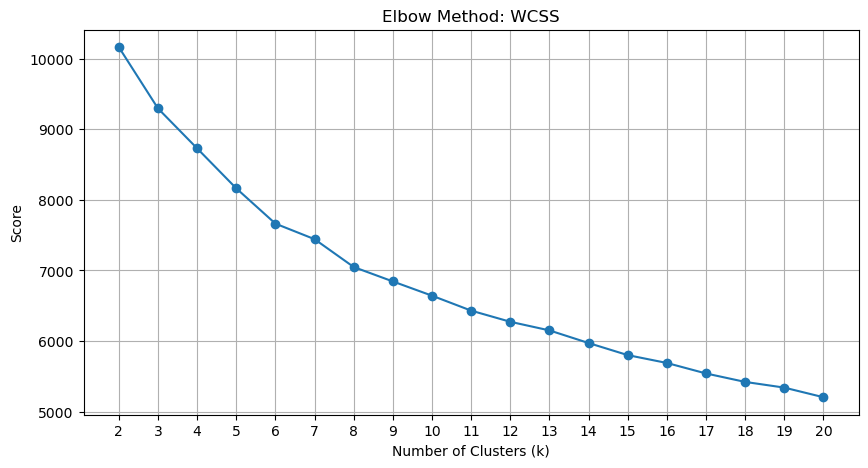

In [ ]:
# WCSS Elbow method
plt.figure(figsize=(10, 5))

plt.plot(cluster_range, wcss, marker='o')
plt.xlabel("Number of Clusters (k)")
plt.ylabel("Score")
plt.title("Elbow Method: WCSS")
plt.xticks(cluster_range)
plt.grid()
plt.show()

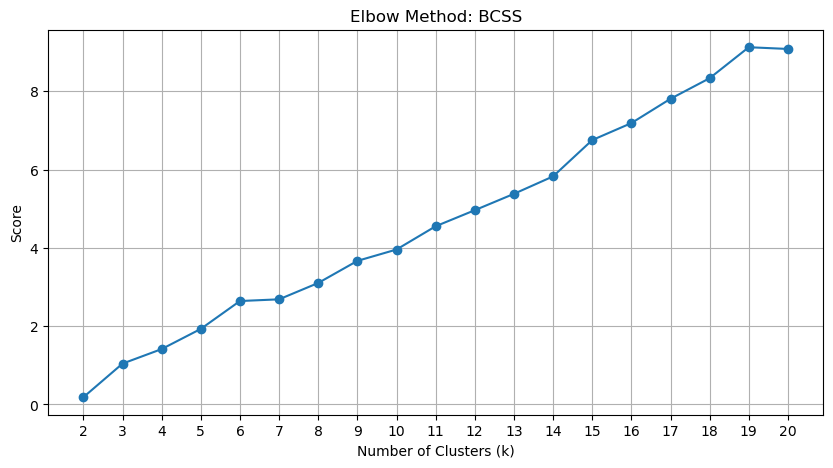

In [ ]:
# BCSS Elbow Method
plt.figure(figsize=(10, 5))

plt.plot(cluster_range, bcss, marker='o')
plt.xlabel("Number of Clusters (k)")
plt.ylabel("Score")
plt.title("Elbow Method: BCSS")
plt.xticks(cluster_range)
plt.grid()
plt.show()

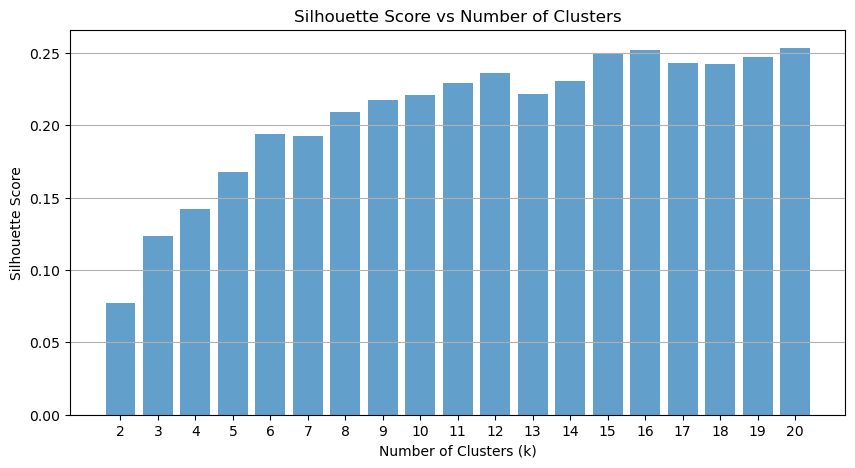

In [ ]:
# Silhouette scores
plt.figure(figsize=(10, 5))
plt.bar(cluster_range, silhouette_scores, alpha=0.7)
plt.xlabel("Number of Clusters (k)")
plt.ylabel("Silhouette Score")
plt.title("Silhouette Score vs Number of Clusters")
plt.xticks(cluster_range)
plt.grid(axis='y')
plt.show()

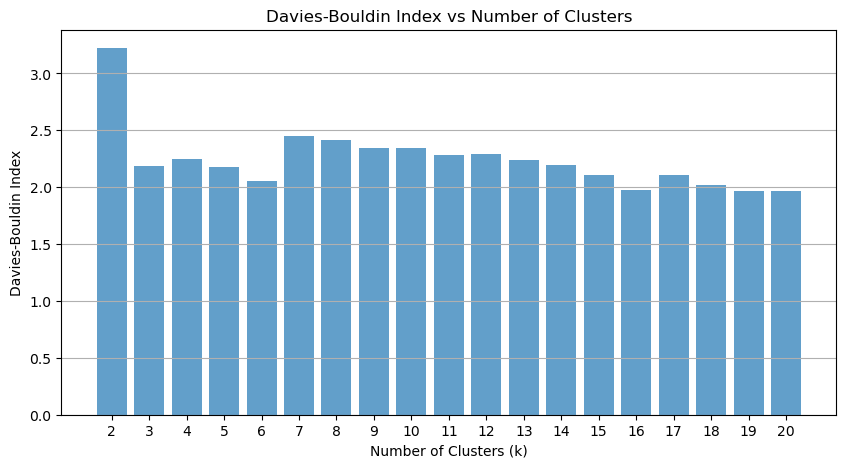

In [ ]:
plt.figure(figsize=(10, 5))
plt.bar(cluster_range, dbi_scores, alpha=0.7)
plt.xlabel("Number of Clusters (k)")
plt.ylabel("Davies-Bouldin Index")
plt.title("Davies-Bouldin Index vs Number of Clusters")
plt.xticks(cluster_range)
plt.grid(axis='y')
plt.show()

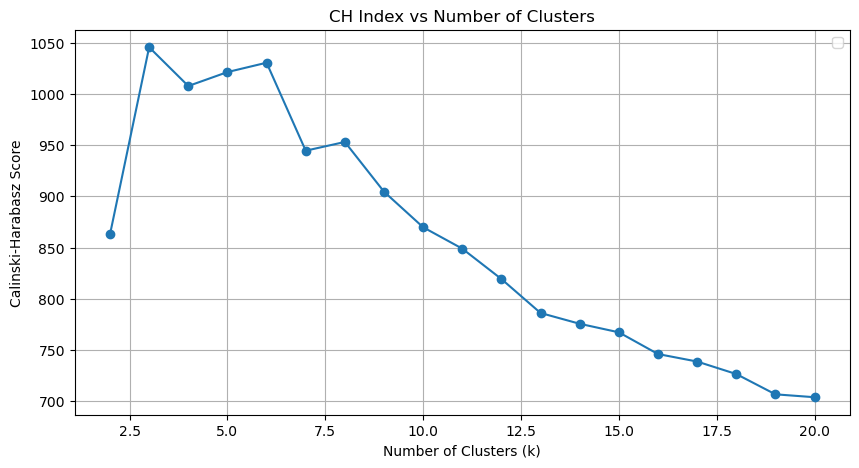

In [ ]:
ch_scores = []

for k in cluster_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    labels = kmeans.fit_predict(vector_matrix)

    score = calinski_harabasz_score(vector_matrix.toarray(), labels)
    ch_scores.append(score)


plt.figure(figsize=(10, 5))
plt.plot(cluster_range, ch_scores, marker='o')
plt.xlabel("Number of Clusters (k)")
plt.ylabel("Calinski-Harabasz Score")
plt.title("CH Index vs Number of Clusters")
plt.legend()
plt.grid()
plt.show()

We have a few possible values for k: 3, 6, 12 and 16. Let's try to visualize 3 and 6 using a PCA model

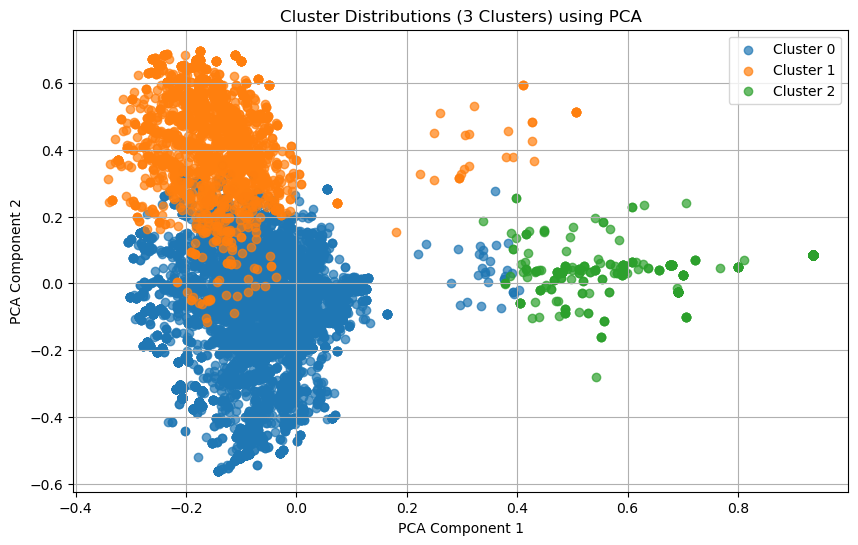

In [ ]:
kmeans = KMeans(n_clusters=3, random_state=42, n_init=10)
k3_df  = or_anime_df
k3_df['cluster_label'] = kmeans.fit_predict(vector_matrix)

k3_pca = PCA(n_components=2)
k3_pca_components = k3_pca.fit_transform(vector_matrix.toarray())

k3_pca_df = pd.DataFrame(k3_pca_components, columns=['PCA1', 'PCA2'])
k3_pca_df['cluster_label'] = k3_df['cluster_label']

plt.figure(figsize=(10, 6))
for label in range(3):
    cluster_data = k3_pca_df[k3_pca_df['cluster_label'] == label]
    plt.scatter(cluster_data['PCA1'], cluster_data['PCA2'], label=f"Cluster {label}", alpha=0.7)

plt.title("Cluster Distributions (3 Clusters) using PCA")
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
np.cumsum(k3_pca.explained_variance_ratio_)

array([0.09039669, 0.16925885])

Let's see k = 6

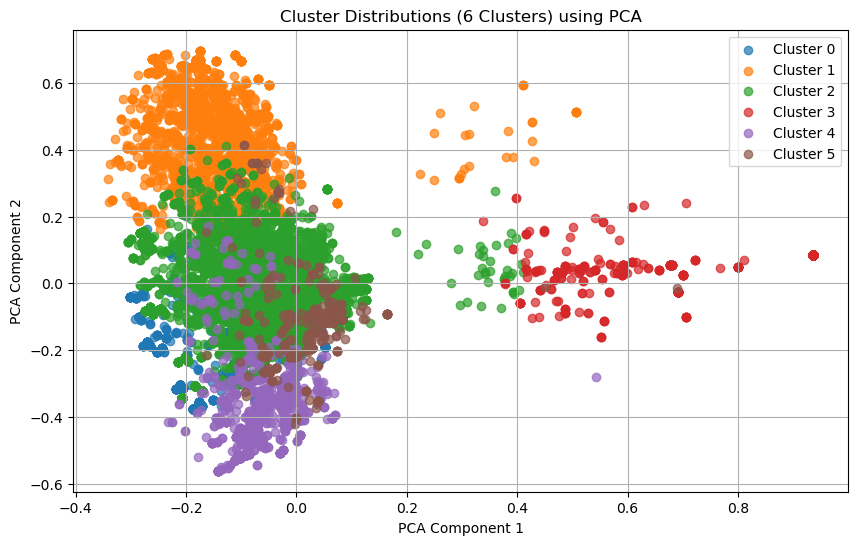

In [ ]:
kmeans = KMeans(n_clusters=6, random_state=42, n_init=10)
k6_df  = or_anime_df
k6_df['cluster_label'] = kmeans.fit_predict(vector_matrix)

k6_pca = PCA(n_components=2)
k6_pca_components = k6_pca.fit_transform(vector_matrix.toarray())

k6_pca_df = pd.DataFrame(k6_pca_components, columns=['PCA1', 'PCA2'])
k6_pca_df['cluster_label'] = k6_df['cluster_label']

plt.figure(figsize=(10, 6))
for label in range(6):
    cluster_data = k6_pca_df[k6_pca_df['cluster_label'] == label]
    plt.scatter(cluster_data['PCA1'], cluster_data['PCA2'], label=f"Cluster {label}", alpha=0.7)

plt.title("Cluster Distributions (6 Clusters) using PCA")
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
np.cumsum(k6_pca.explained_variance_ratio_)

array([0.09039669, 0.16925885])

Looking. Let's try t-SNE for 3 clusters.

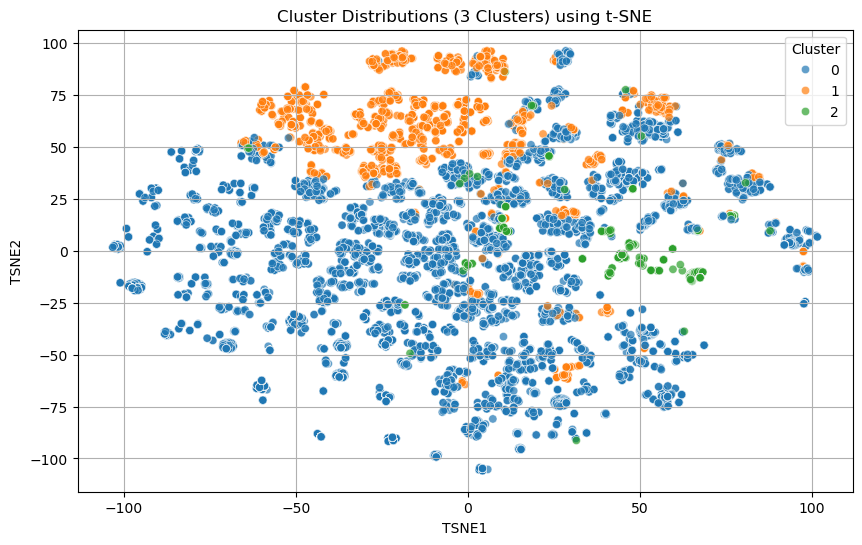

In [ ]:
tk3_df = or_anime_df
kmeans = KMeans(n_clusters=3, random_state=42, n_init=10)
tk3_df['cluster_label'] = kmeans.fit_predict(vector_matrix)

k3_tsne = TSNE(n_components=2, random_state=42, perplexity=30, learning_rate=200)
k3_tsne_components = k3_tsne.fit_transform(vector_matrix.toarray())

k3_tsne_df = pd.DataFrame(k3_tsne_components, columns=['TSNE1', 'TSNE2'])
k3_tsne_df['cluster_label'] = tk3_df['cluster_label']

# Plot the clusters
plt.figure(figsize=(10, 6))
sns.scatterplot(x='TSNE1', y='TSNE2', hue='cluster_label', palette='tab10', data=k3_tsne_df, alpha=0.7)
plt.title("Cluster Distributions (3 Clusters) using t-SNE")
plt.legend(title="Cluster")
plt.grid(True)
plt.show()

Let's try t-SNE for 6 clusters.

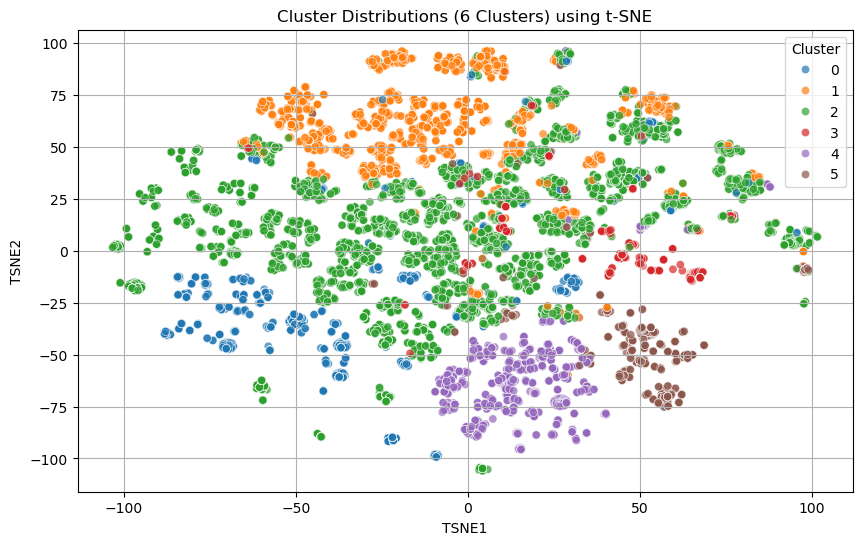

In [ ]:
tk6_df = or_anime_df
kmeans = KMeans(n_clusters=6, random_state=42, n_init=10)
tk6_df['cluster_label'] = kmeans.fit_predict(vector_matrix)

k6_tsne = TSNE(n_components=2, random_state=42, perplexity=30, learning_rate=200)
k6_tsne_components = k6_tsne.fit_transform(vector_matrix.toarray())

k6_tsne_df = pd.DataFrame(k6_tsne_components, columns=['TSNE1', 'TSNE2'])
k6_tsne_df['cluster_label'] = tk6_df['cluster_label']

# Plot the clusters
plt.figure(figsize=(10, 6))
sns.scatterplot(x='TSNE1', y='TSNE2', hue='cluster_label', palette='tab10', data=k6_tsne_df, alpha=0.7)
plt.title("Cluster Distributions (6 Clusters) using t-SNE")
plt.legend(title="Cluster")
plt.grid(True)
plt.show()

Let's try k = 16

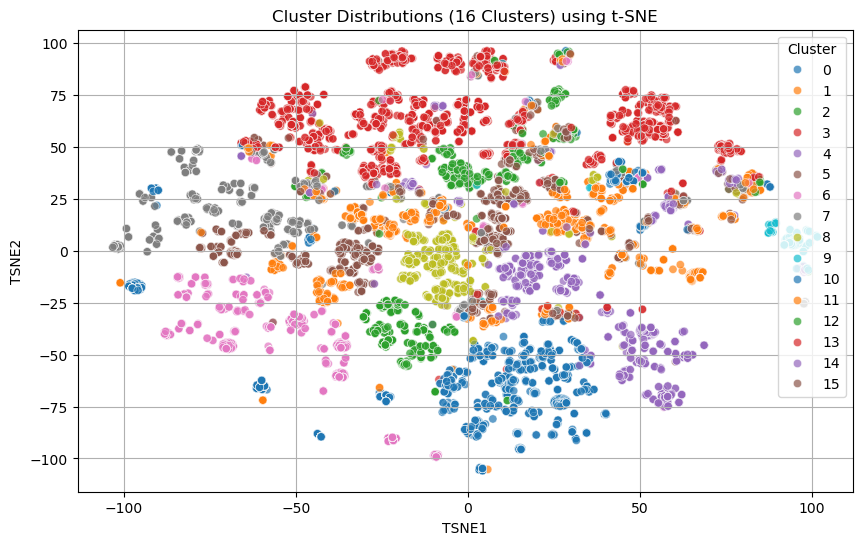

In [ ]:
tk16_df = or_anime_df
kmeans = KMeans(n_clusters=16, random_state=42, n_init=10)
tk16_df['cluster_label'] = kmeans.fit_predict(vector_matrix)

k16_tsne = TSNE(n_components=2, random_state=42, perplexity=30, learning_rate=200)
k16_tsne_components = k16_tsne.fit_transform(vector_matrix.toarray())

k16_tsne_df = pd.DataFrame(k16_tsne_components, columns=['TSNE1', 'TSNE2'])
k16_tsne_df['cluster_label'] = tk16_df['cluster_label']

# Plot the clusters
plt.figure(figsize=(10, 6))
sns.scatterplot(x='TSNE1', y='TSNE2', hue='cluster_label', palette='tab10', data=k16_tsne_df, alpha=0.7)
plt.title("Cluster Distributions (16 Clusters) using t-SNE")
plt.legend(title="Cluster")
plt.grid(True)
plt.show()

t-SNE took quite long to transform. Let's try to plot a dendrogram on the subset of our data. We can't use all the data because this method requires a lot of computational power on entries greater than 10000, we have over 12000.

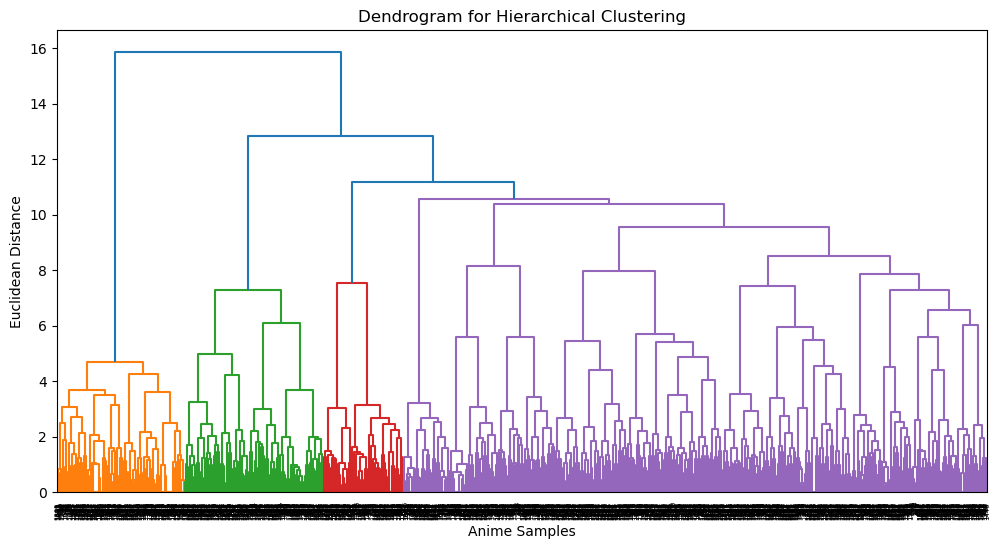

In [ ]:
import scipy.cluster.hierarchy as sch
from sklearn.decomposition import PCA
#from sklearn.cluster import AgglomerativeClustering

h_pca = PCA(n_components=50, random_state=42)
reduced_data = h_pca.fit_transform(vector_matrix.toarray())

linkage_matrix = sch.linkage(reduced_data[:2000], method='ward')

plt.figure(figsize=(12, 6))
sch.dendrogram(linkage_matrix, truncate_mode="level", p=20)
plt.title("Dendrogram for Hierarchical Clustering")
plt.xlabel("Anime Samples")
plt.ylabel("Euclidean Distance")
plt.show()

In [ ]:
k6_pca_df

PCA1      PCA2  cluster_label
0     -0.000522 -0.098010              2
1     -0.175609  0.208932              2
2     -0.158830  0.259302              1
3     -0.062816  0.324086              1
4     -0.158830  0.259302              1
...         ...       ...            ...
12289  0.935706  0.083535              3
12290  0.935706  0.083535              3
12291  0.935706  0.083535              3
12292  0.935706  0.083535              3
12293  0.811352  0.069333              3

[12294 rows x 3 columns]

Let's try to get recommendations based on the PCA

In [ ]:
def recommend_anime_pca(input_anime, df, pca_df, top_n=10):

    if input_anime not in df['name'].values:
        print("Anime not found in dataset.")
        return None, None

    title_index = df[df['name'] == input_anime].index[0]

    input_cluster = df.loc[title_index, 'cluster_label']

    input_pca_vector = pca_df.iloc[title_index, :-1].values.reshape(1, -1)

    similarities = CS(input_pca_vector, pca_df.iloc[:, :-1])
    similarities = similarities.flatten()

    similar_indices = similarities.argsort()[::-1][1:top_n+1]

    recommendations = df.iloc[similar_indices][['name', 'cluster_label']]

    return input_cluster, recommendations

In [ ]:
input_anime = "fullmetal alchemist"
input_cluster, recommendations = recommend_anime_pca(input_anime, k6_df, k6_pca_df)

In [ ]:
print(f"Cluster of '{input_anime}': {input_cluster}")
print("Top Recommended Anime:")
print(recommendations)

Cluster of 'fullmetal alchemist': 2
Top Recommended Anime:
                                            name  cluster_label
4164             mirai nikki tv: ura mirai nikki              2
5323  haou daikei ryuu knight: adeu legend final              2
1459        tiger & bunny movie 1: the beginning              2
521            tiger & bunny movie 2: the rising              2
8771                                 harbor tale              2
117                      kaze no tani no nausica              2
6862                            waza no tabibito              2
2481                    jungle taitei movie 1997              2
5896                          kaitei sanman mile              2
5845                     shounen sarutobi sasuke              2


Let's try tSNE recommendations

In [ ]:
def recommend_anime_tsne(input_anime, df, tsne_df, top_n=10):

    if input_anime not in df['name'].values:
        print("Anime not found in dataset.")
        return None, None

    # Get the index of the input anime
    anime_index = df[df['name'] == input_anime].index[0]

    # Get cluster label of input anime
    input_cluster = df.loc[anime_index, 'cluster_label']

    # Get the t-SNE representation of the input anime
    input_tsne_vector = tsne_df.iloc[anime_index, :-1].values.reshape(1, -1)  # Exclude cluster labels

    # Compute cosine similarity between input anime and all other anime
    similarities = CS(input_tsne_vector, tsne_df.iloc[:, :-1])
    similarities = similarities.flatten()

    # Get indices of the most similar anime (excluding itself)
    similar_indices = similarities.argsort()[::-1][1:top_n+1]

    # Retrieve recommended anime titles with cluster labels
    recommendations = df.iloc[similar_indices][['name', 'cluster_label']]

    return input_cluster, recommendations

In [ ]:
input_cluster, recommendations = recommend_anime_tsne(input_anime, tk6_df, k6_tsne_df)

In [ ]:
print(f"Cluster of '{input_anime}': {input_cluster}")
print("Top Recommended Anime:")
print(recommendations)

Cluster of 'fullmetal alchemist': 2
Top Recommended Anime:
                                                    name  cluster_label
1441   code geass: boukoku no akito 2 - hikisakareshi...              2
1                       fullmetal alchemist: brotherhood              2
1558       fullmetal alchemist: the sacred star of milos              2
1776                                 zoids shinseikizero              1
4242                           igpx: immortal grand prix              1
1897           igpx: immortal grand prix 2005 2nd season              1
402            fullmetal alchemist: brotherhood specials              2
2446                                               gunnm              1
2519                      igpx: immortal grand prix 2005              1
10968                             demi-chan wa kataritai              2


In [ ]:
input_cluster, recommendations = recommend_anime_tsne('gintama', tk6_df, k6_tsne_df)

In [ ]:
print(f"Cluster of 'gintama': {input_cluster}")
print("Top Recommended Anime:")
print(recommendations)

Cluster of 'gintama': 1
Top Recommended Anime:
                                                    name  cluster_label
4                                               gintama'              1
10896                                       gintama 2017              1
12                                               gintama              1
9                                    gintama': enchousen              1
1787     hayate no gotoku: atsu ga natsuize - mizugi-hen              2
649                                     hayate no gotoku              2
951                                     hayate no gotoku              2
63           gintama: yorinuki gintama-san on theater 2d              1
65                gintama movie: shinyaku benizakura-hen              1
8      gintama movie: kanketsu-hen - yorozuya yo eien...              1


In [ ]:
tk6_df.head()

anime_id                              name  \
0     32281                    kimi no na wa.   
1      5114  fullmetal alchemist: brotherhood   
2     28977                           gintama   
3      9253                       steins;gate   
4      9969                          gintama'   

                                               genre   type  episodes  rating  \
0     ['drama', 'romance', 'school', 'supernatural']  movie         1    9.37   
1  ['action', 'adventure', 'drama', 'fantasy', 'm...     tv        64    9.26   
2  ['action', 'comedy', 'historical', 'parody', '...     tv        51    9.25   
3                             ['sci-fi', 'thriller']     tv        24    9.17   
4  ['action', 'comedy', 'historical', 'parody', '...     tv        51    9.16   

   members  rounded_rating                                     selected_feats  \
0   200630               9  ['drama', 'romance', 'school', 'supernatural']...   
1   793665               9  ['action', 'adventure', 'drama', 'fantasy', 'm...   
2   114262               9  ['action', 'comedy', 'historical', 'parody', '...   
3   673572               9   ['sci-fi', 'thriller'] tv ['sci-fi', 'thriller']   
4   151266               9  ['action', 'comedy', 'historical', 'parody', '...   

   cluster_label  
0              2  
1              2  
2              1  
3              1  
4              1

### 7.3 Collaborative Based Filtering

 Collaborative filtering is a recommendation method that suggests items (anime) based on the preferences of similar users or similar items. It assumes that if two users have rated anime similarly in the past, they are likely to have similar tastes in the future.

- Ideally, Focuses on user behavior by finding people with similar tastes and recommending what they liked.

- In section, we will explore the collaborative-based filtering that includes user-based collaborative filtering and item-based filtering

In [ ]:
###User based collaborative

In [ ]:
util_matrix = train_df.pivot_table(index=['user_id'], columns=['anime_id'], values='rating')

In [ ]:
util_matrix

In [ ]:
# Normalize each row (a given user's ratings) of the utility matrix
util_matrix_norm = util_matrix.apply(lambda x: (x-np.mean(x))/(np.max(x)-np.min(x)), axis=1)
# Fill Nan values with 0's, transpose matrix, and drop users with no ratings
util_matrix_norm.fillna(0, inplace=True)
util_matrix_norm = util_matrix_norm.T
util_matrix_norm = util_matrix_norm.loc[:, (util_matrix_norm != 0).any(axis=0)]
# Save the utility matrix in scipy's sparse matrix format
util_matrix_sparse = sp.sparse.csr_matrix(util_matrix_norm.values)


In [ ]:
util_matrix_sparse

In [ ]:
user_similarity = CS(util_matrix_sparse.T)
# Save the matrix as a dataframe to allow for easier indexing
user_sim_df = pd.DataFrame(user_similarity,
                           index = util_matrix_norm.columns,
                           columns = util_matrix_norm.columns)

# Review a small portion of the constructed similarity matrix
user_sim_df[:5]


In [ ]:
def collab_generate_top_N_recommendations(user, N=10, k=20):
    # Cold-start problem - no ratings given by the reference user.
    # With no further user data, we solve this by simply recommending
    # the top-N most popular books in the item catalogue.
    if user not in user_sim_df.columns:
        return train_df.groupby('anime_id').mean().sort_values(by='rating',
                                        ascending=False).index[:N].to_list()

    # Gather the k users which are most similar to the reference user
    sim_users = user_sim_df.sort_values(by=user, ascending=False).index[1:k+1]
    favorite_user_items = [] # <-- List of highest rated items gathered from the k users
    most_common_favorites = {} # <-- Dictionary of highest rated items in common for the k users

    for i in sim_users:
        # Maximum rating given by the current user to an item
        max_score = util_matrix_norm.loc[:, i].max()
        # Save the names of items maximally rated by the current user
        favorite_user_items.append(util_matrix_norm[util_matrix_norm.loc[:, i]==max_score].index.tolist())

    # Loop over each user's favourite items and tally which ones are
    # most popular overall.
    for item_collection in range(len(favorite_user_items)):
        for item in favorite_user_items[item_collection]:
            if item in most_common_favorites:
                most_common_favorites[item] += 1
            else:
                most_common_favorites[item] = 1
    # Sort the overall most popular items and return the top-N instances
    sorted_list = sorted(most_common_favorites.items(), key=operator.itemgetter(1), reverse=True)[:N]
    top_N = [x[0] for x in sorted_list]
    return top_N


In [ ]:
# Our recommended list for user 314
collab_generate_top_N_recommendations(314)


In [ ]:
names = collab_generate_top_N_recommendations(314)


In [ ]:
recomendations = anime_df[anime_df['anime_id'].isin(names) ][['name','rating']]
recomendations

In [ ]:
# User 314's historical ratings
history_df = train_df[train_df['user_id'] == 314][:][['user_id','rating']].sort_values(by='rating', ascending=False)[:10]
history_df

In [ ]:
###Item based Collaborative

In [ ]:
def collab_generate_rating_estimate(anime_id, user, k=20, threshold=0.0):
    # Gather the k users which are most similar to the reference user
    sim_users = user_sim_df.sort_values(by=user, ascending=False).index[1:k+1]
    # Store the corresponding user's similarity values
    user_values = user_sim_df.sort_values(by=user, ascending=False).loc[:,user].tolist()[1:k+1]
    rating_list = [] # <-- List of k user's ratings for the reference item
    weight_list = [] # <-- List of k user's similarities to the reference user

    # Create a weighted sum for each of the k users who have rated the
    # reference item (book).
    for sim_idx, user_id in enumerate(sim_users):
        # User's rating of the item
        rating = util_matrix.loc[user_id, anime_id]
        # User's similarity to the reference user
        similarity = user_values[sim_idx]
        # Skip the user if they have not rated the item, or are too dissimilar to
        # the reference user
        if (np.isnan(rating)) or (similarity < threshold):
            continue
        elif not np.isnan(rating):
            rating_list.append(rating*similarity)
            weight_list.append(similarity)
    try:
        # Return the weighted sum as the predicted rating for the reference item
        predicted_rating = sum(rating_list)/sum(weight_list)
    except ZeroDivisionError:
        # If no ratings for the reference item can be collected, return the average
        # rating given by all users for the item.
        predicted_rating = np.mean(util_matrix[anime_id])
    return predicted_rating


In [ ]:
name = 'dragon ball z'
anime_id = anime_df[anime_df['name'] == name]['anime_id'].values[0]

actual_rating = train_df[(train_df['user_id'] == 314) & (train_df['anime_id'] == anime_id)]['rating'].values[0]
pred_rating = collab_generate_rating_estimate(anime_id = anime_id, user = 314)
print (f"Title - {name}")
print ("----------------")
print (f"Actual rating: \t\t {actual_rating}")
print (f"Predicted rating: \t {pred_rating}")

In [ ]:
anime_df[anime_df['name'] == 'dragon ball z']['anime_id'].values[0]

### 8. Model Evaluation

### 9. Hyperparameter Tuning

### 10. Conclusion